In [25]:
import pandas as pd
from models.RGCN_model import RGCN_model
from models.GCN_model import GCN_model
from models.MLP_model import MLP_model
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GAE
import torch.nn
import torch
from utils.rewiring import rewiring
import numpy as np
import random
from torch_geometric.utils import to_networkx, from_networkx
import torch.nn.functional as F
from torch_geometric.transforms import NormalizeFeatures
import matplotlib.pyplot as plt

In [26]:
dataset = Planetoid(root = 'datasets', name = 'Cora')
data = dataset[0]

data.y = torch.tensor([1 if data.y[x] == 3 else 0 for x in range(data.x.shape[0])])
true_labels = np.array([1 if x == 1 else 0 for x in data.y])
all_positives = np.array([x for x in range(data.x.shape[0]) if true_labels[x] == 1])

P = random.sample(all_positives.tolist(), int(0.25 * len(all_positives)))

In [27]:
epochs = 500

In [28]:
L = 5
graph_list = rewiring(to_networkx(data, to_undirected=True), L, P)
graph_list = [data] + [from_networkx(G) for G in graph_list]

5278
11139
12736
14264
15555
16709


In [29]:
# Definindo as cores
colors = ['red' if label == 0 else 'blue' if label == 1 else 'green' for label in data.y]

# Criar uma lista de cores com verde para os pontos de treino
for idx in P:
    colors[idx] = 'green'

## Rewiring + GAE (Inner product of Latent Variables) - Proposed Approach

In [30]:

model = RGCN_model(data.x.shape[1], 64, 2, L = L)
RGAE = GAE(encoder = model)
optimizer = torch.optim.SGD(RGAE.parameters(), lr = 0.01)

In [31]:
losses = list()
embs_list = list()
# epochs = 300

for e in range(epochs):
    optimizer.zero_grad()
    H_L = RGAE.encode(data.x.float(), graph_list)
    loss = RGAE.recon_loss(H_L, graph_list[-1].edge_index)
    print(f'epoch: {e + 1} | loss: {loss.item()}', end = '\r')
    losses.append(loss.item())
    embs_list.append(H_L)
    loss.backward()
    optimizer.step()

In [32]:
# Setando as variáveis para plot
# Concatenando todos os tensores ao longo da dimensão 0
concatenado = torch.cat(embs_list, dim=0)

# Pegando o maior e o menor valor da primeira coluna
x_max = torch.max(concatenado[:, 0]).item()
x_min = torch.min(concatenado[:, 0]).item()

# Pegando o maior e o menor valor da segunda coluna
y_max = torch.max(concatenado[:, 1]).item()
y_min = torch.min(concatenado[:, 1]).item()

# print("Maior valor da primeira coluna:", x_max.item())
# print("Menor valor da primeira coluna:", x_min.item())
# print("Maior valor da segunda coluna:", y_max.item())
# print("Menor valor da segunda coluna:", y_min.item())

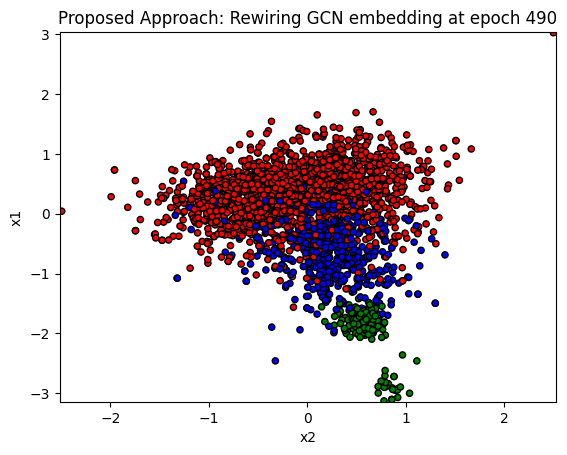

In [33]:
for e in range(0, epochs, 10):
    plt.clf()
    x = embs_list[e][:,0].detach().numpy()
    y = embs_list[e][:,1].detach().numpy()
    plt.scatter(x,y, c = colors, edgecolors='k', s = 20)
    # Fixando o intervalo de x e y
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(f'Proposed Approach: Rewiring GCN embedding at epoch {e}')
    plt.ylabel('x1')
    plt.xlabel('x2')
    plt.savefig(f'results/graph_embeddings/RGCN/RGCN_epoch{e}.png')
    # plt.show()

## GCN + GAE (Inner product of Latent Variables)

In [34]:
model = GCN_model(data.x.shape[1], 64, 2)
GCNGAE = GAE(encoder = model)
optimizer = torch.optim.SGD(GCNGAE.parameters(), lr = 0.01)

In [35]:
losses = list()
embs_list = list()
# epochs = 200

for e in range(epochs):
    optimizer.zero_grad()
    H_L = GCNGAE.encode(data.x.float(), data.edge_index)
    loss = GCNGAE.recon_loss(H_L, data.edge_index)
    print(f'epoch: {e + 1} | loss: {loss.item()}', end = '\r')
    losses.append(loss.item())
    embs_list.append(H_L)
    loss.backward()
    optimizer.step()


In [36]:
concatenado = torch.cat(embs_list, dim=0)

# Pegando o maior e o menor valor da primeira coluna
x_max = torch.max(concatenado[:, 0]).item()
x_min = torch.min(concatenado[:, 0]).item()

# Pegando o maior e o menor valor da segunda coluna
y_max = torch.max(concatenado[:, 1]).item()
y_min = torch.min(concatenado[:, 1]).item()

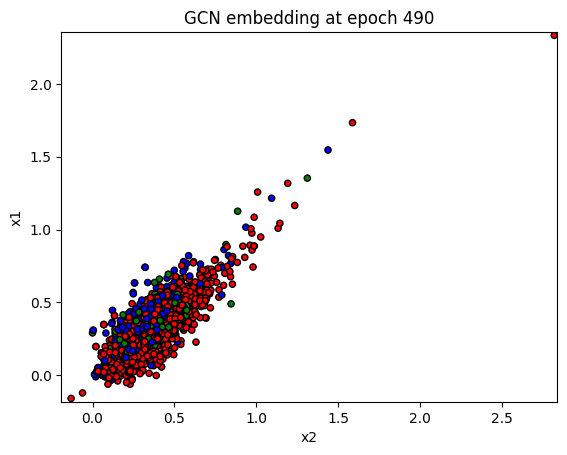

In [37]:
for e in range(0,epochs, 10):
    plt.clf()
    x = embs_list[e][:,0].detach().numpy()
    y = embs_list[e][:,1].detach().numpy()
    plt.scatter(x,y, c =colors, edgecolors='k', s = 20)
    # Fixando o intervalo de x e y
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(f'GCN embedding at epoch {e}')
    plt.ylabel('x1')
    plt.xlabel('x2')
    plt.savefig(f'results/graph_embeddings/GCN/GCN_epoch{e}')

## Rewiring + MLP (AE trained via positive labels only) -- Proposed Approach

In [38]:
L = 3
model_encode = RGCN_model(data.x.shape[1], 64, 2, L = L)
model_decode = MLP_model(2, 64, data.x.shape[1])
RGAE = GAE(encoder = model_encode, decoder = model_decode)
optimizer = torch.optim.SGD(RGAE.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.9)

In [39]:
mask = torch.zeros(data.x.shape[0], dtype = torch.bool)

for element in P:
    mask[element] = True

embs_list = list()
losses = list()

for e in range(epochs):
    optimizer.zero_grad()
    H_L = RGAE.encode(data.x.float(), graph_list)
    out = RGAE.decode(H_L)

    loss = F.binary_cross_entropy(out[mask], graph_list[0].x.float()[mask])
    print(f'epoch: {e + 1} | loss: {loss.item()}', end = '\r')
    loss.backward()
    optimizer.step()

    if scheduler is not None:
        scheduler.step()
        

    losses.append(loss.item())
    embs_list.append(H_L)

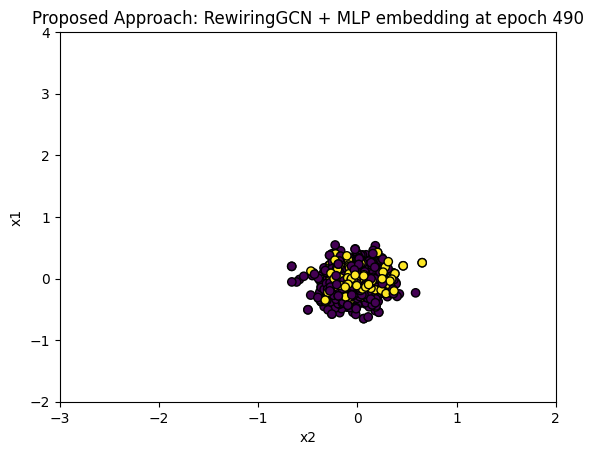

In [40]:
for e in range(0,epochs, 10):
    plt.clf()
    x = embs_list[e][:,0].detach().numpy()
    y = embs_list[e][:,1].detach().numpy()
    plt.scatter(x,y, c = data.y, edgecolors='k')
    # Fixando o intervalo de x e y
    plt.xlim(-3, 2)
    plt.ylim(-2, 4)
    plt.title(f'Proposed Approach: RewiringGCN + MLP embedding at epoch {e}')
    plt.ylabel('x1')
    plt.xlabel('x2')
    plt.savefig(f'results/graph_embeddings/RGCN_MLP/RGCN_MLP_epoch{e}')

## GCN + MLP (AE trained via positive labels only)

In [41]:
model_encode = GCN_model(data.x.shape[1], 64, 2)
model_decode = MLP_model(2, 64, data.x.shape[1])
GCNGAE = GAE(encoder = model_encode, decoder = model_decode)
optimizer = torch.optim.SGD(GCNGAE.parameters(), lr = 0.000001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.9)

In [42]:
mask = torch.zeros(data.x.shape[0], dtype = torch.bool)

for element in P:
    mask[element] = True

embs_list = list()
losses = list()

for e in range(epochs):
    optimizer.zero_grad()
    H_L = GCNGAE.encode(data.x.float(), data.edge_index)
    out = GCNGAE.decode(H_L)

    loss = F.binary_cross_entropy(out[mask], data.x.float()[mask])
    print(f'epoch: {e + 1} | loss: {loss.item()}', end = '\r')
    loss.backward()
    optimizer.step()

    if scheduler is not None:
        scheduler.step()
        

    losses.append(loss.item())
    embs_list.append(H_L)

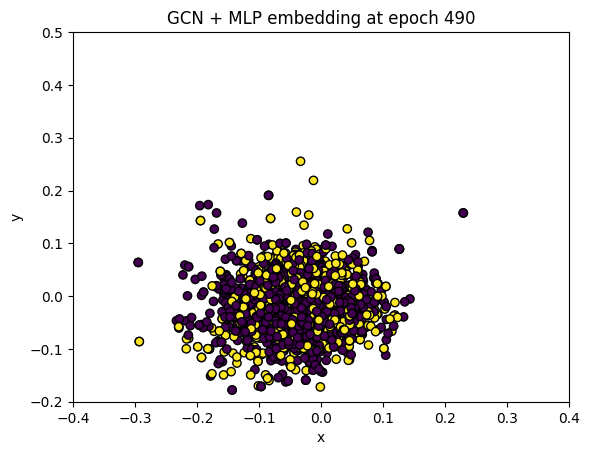

In [43]:
# for e in range(0,epochs, 10):
#     plt.clf()
#     x = embs_list[e][:,0].detach().numpy()
#     y = embs_list[e][:,1].detach().numpy()
#     plt.scatter(x,y, c = data.y, edgecolors='k')
#     plt.title(f'GCN + MLP embedding at epoch {e}')
#     plt.ylabel('x1')
#     plt.xlabel('x2')
#     plt.savefig(f'results/graph_embeddings/GCN_MLP/GCN_MLP_epoch{e}')

for e in range(0, epochs, 10):
    plt.clf()
    x = embs_list[e][:, 0].detach().numpy()
    y = embs_list[e][:, 1].detach().numpy()
    plt.scatter(x, y, c=data.y, edgecolors='k')
    
    # Fixando o intervalo de x e y
    plt.xlim(-0.4, 0.4)
    plt.ylim(-0.2, 0.5)
    
    plt.title(f'GCN + MLP embedding at epoch {e}')
    plt.ylabel('y')
    plt.xlabel('x')
    plt.savefig(f'results/graph_embeddings/GCN_MLP/GCN_MLP_epoch{e}')

## Salvando os resultados


In [44]:
import os
import imageio
import matplotlib.pyplot as plt


In [45]:
# Defina o caminho para a pasta onde as imagens estão armazenadas
pasta_imagens = 'results/graph_embeddings/RGCN'

# Obtenha a lista de arquivos na pasta de imagens
lista_arquivos = sorted([arquivo for arquivo in os.listdir(pasta_imagens) if arquivo.startswith('RGCN_epoch')],
                        key=lambda x: int(x.split('epoch')[1].split('.')[0]))

# Inicialize uma lista vazia para armazenar as imagens
imagens = []

# Loop através de cada arquivo na lista de arquivos
for arquivo in lista_arquivos:
    # Verifique se o arquivo é uma imagem (por exemplo, com extensão .png, .jpg, etc.)
    if arquivo.endswith('.png') or arquivo.endswith('.jpg'):
        # Caminho completo para o arquivo de imagem
        caminho_completo = os.path.join(pasta_imagens, arquivo)
        
        # Leia a imagem usando o Matplotlib
        imagem = plt.imread(caminho_completo)
        
        # Converta a imagem para uint8
        imagem_uint8 = (imagem * 255).astype(np.uint8)
        
        # Adicione a imagem à lista de imagens
        imagens.append(imagem_uint8)

# Salve as imagens como um arquivo GIF
output_path = 'RGCN_GAE.gif'
imageio.mimsave(output_path, imagens)

print(f'GIF salvo em: {output_path}')


GIF salvo em: RGCN_GAE.gif


In [46]:
# Defina o caminho para a pasta onde as imagens estão armazenadas
pasta_imagens = 'results/graph_embeddings/GCN'

# Obtenha a lista de arquivos na pasta de imagens
lista_arquivos = sorted([arquivo for arquivo in os.listdir(pasta_imagens) if arquivo.startswith('GCN_epoch')],
                        key=lambda x: int(x.split('epoch')[1].split('.')[0]))

# Inicialize uma lista vazia para armazenar as imagens
imagens = []


# Loop através de cada arquivo na lista de arquivos
for arquivo in lista_arquivos:
    # Verifique se o arquivo é uma imagem (por exemplo, com extensão .png, .jpg, etc.)
    if arquivo.endswith('.png') or arquivo.endswith('.jpg'):
        # Caminho completo para o arquivo de imagem
        caminho_completo = os.path.join(pasta_imagens, arquivo)
        
        # Leia a imagem usando o Matplotlib
        imagem = plt.imread(caminho_completo)
        
        # Converta a imagem para uint8
        imagem_uint8 = (imagem * 255).astype(np.uint8)
        
        # Adicione a imagem à lista de imagens
        imagens.append(imagem_uint8)

print(len(imagens))
# Salve as imagens como um arquivo GIF
output_path = 'GCN_GAE.gif'
imageio.mimsave(output_path, imagens)

print(f'GIF salvo em: {output_path}')


50
GIF salvo em: GCN_GAE.gif


In [47]:
# Defina o caminho para a pasta onde as imagens estão armazenadas
pasta_imagens = 'results/graph_embeddings/GCN_MLP'

# Obtenha a lista de arquivos na pasta de imagens
lista_arquivos = sorted([arquivo for arquivo in os.listdir(pasta_imagens) if arquivo.startswith('GCN_MLP_epoch')],
                        key=lambda x: int(x.split('epoch')[1].split('.')[0]))

# Inicialize uma lista vazia para armazenar as imagens
imagens = []


# Loop através de cada arquivo na lista de arquivos
for arquivo in lista_arquivos:
    # Verifique se o arquivo é uma imagem (por exemplo, com extensão .png, .jpg, etc.)
    if arquivo.endswith('.png') or arquivo.endswith('.jpg'):
        # Caminho completo para o arquivo de imagem
        caminho_completo = os.path.join(pasta_imagens, arquivo)
        
        # Leia a imagem usando o Matplotlib
        imagem = plt.imread(caminho_completo)
        
        # Converta a imagem para uint8
        imagem_uint8 = (imagem * 255).astype(np.uint8)
        
        # Adicione a imagem à lista de imagens
        imagens.append(imagem_uint8)

print(len(imagens))
# Salve as imagens como um arquivo GIF
output_path = 'GCN_MLP.gif'
imageio.mimsave(output_path, imagens)

print(f'GIF salvo em: {output_path}')


50
GIF salvo em: GCN_MLP.gif


In [48]:
type(embs_list)

list

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

# Generate some synthetic data
np.random.seed(0)
X_positive = np.random.randn(100, 2)  # Positive class
X_unlabeled = np.random.randn(200, 2)  # Unlabeled examples

# Train SVM with positive class as target and unlabeled examples as negative class
svm = SVC(kernel='linear', probability=True)
svm.fit(X_positive, np.ones(X_positive.shape[0]))

# Predict probabilities for positive and unlabeled examples
probas_ = svm.predict_proba(np.vstack([X_positive, X_unlabeled]))[:, 1]

# Compute ROC curve and ROC area for positive vs. unlabeled
fpr, tpr, _ = roc_curve(np.hstack([np.ones(X_positive.shape[0]), np.zeros(X_unlabeled.shape[0])]), probas_)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


ValueError: The number of classes has to be greater than one; got 1 class